## Основное задание — исследование SGD с разными расписаниями и регуляризацией

### Требование ТЗ
> «Реализуйте и исследуйте на эффективность SGD для решения полиномиальной или многомерной линейной регрессии:
> 1. с разной функцией изменения шага (learning rate scheduling)

---

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from utils.data_loader import load_uci
from core.schedulers import PolynomialDecay
from core.sgd import SGDRegressor
from utils.metrics import mse, r2, full_report

X_raw, y_raw, _ = load_uci(
    "wine-quality",
    "winequality-red.csv",
    target="alcohol",
    cache_dir="data/uci_cache",
)

Xtr, Xte, ytr, yte = train_test_split(X_raw, y_raw, test_size=0.2, random_state=42)

scaler = StandardScaler().fit(Xtr)
Xtr_s, Xte_s = scaler.transform(Xtr), scaler.transform(Xte)

poly_shed = PolynomialDecay(1e-2, alpha=0.35, beta=1)
model_poly = SGDRegressor(
    lr_schedule=poly_shed,
    batch_size=64,
    penalty="elastic",
    alpha=1e-1,
    l1_ratio=0.7,
    max_iter=1000,
    random_state=42,
).fit(Xtr_s, ytr)

from core.schedulers import StepDecayScheduler

step_sched = StepDecayScheduler(lr0=1e-2, step=500, gamma=0.5)
model_sgd = SGDRegressor(
    lr_schedule=step_sched,
    batch_size=64,
    penalty="l2",
    alpha=1e-1,
    max_iter=1000,
    random_state=42,
).fit(Xtr_s, ytr)

def report(name, mdl):
    y_pred_tr = mdl(Xtr_s)
    y_pred_te = mdl(Xte_s)
    print(f"{name}:  \n\n"
          f"trainMSE={mse(ytr, y_pred_tr):>40.4f} \n(средний квадрат ошибки на 80 % обучающих данных) \n"
          f"\ntestMSE={mse(yte, y_pred_te):>40.4f} \n(средний квадрат ошибки на 20 % обучающих данных) \n"
          f"\nR²={r2(yte, y_pred_te):>40.4f} \n(доля объяснённой дисперсии) \n")
    metrics = full_report(yte, y_pred_te)
    print("  full_report:", metrics, "\n")

sample_raw = np.asarray(
        [[7.4, 0.70, 0.00, 1.9, 0.076, 11, 34, 0.9978, 3.51, 0.56, 5]]
    )
sample = scaler.transform(sample_raw)
print("\nSample prediction (model_poly):", round(model_poly(sample).item(), 3))

print("\nSample prediction (model_sgd):", round(model_sgd(sample).item(), 3))

report("SGD Poly", model_poly)
report("SGD step",  model_sgd)

[DataLoader] shape=(1599, 12)

Sample prediction (model_poly): 9.729

Sample prediction (model_sgd): 9.691
SGD Poly:  

trainMSE=                                  0.4056 
(средний квадрат ошибки на 80 % обучающих данных) 

testMSE=                                  0.4214 
(средний квадрат ошибки на 20 % обучающих данных) 

R²=                                  0.6615 
(доля объяснённой дисперсии) 

  full_report: {'mse': 0.4214450521155063, 'rmse': 0.6491879944326653, 'mae': 0.5133300142504227, 'r2': 0.6614703743515262} 

SGD step:  

trainMSE=                                  0.3749 
(средний квадрат ошибки на 80 % обучающих данных) 

testMSE=                                  0.3888 
(средний квадрат ошибки на 20 % обучающих данных) 

R²=                                  0.6877 
(доля объяснённой дисперсии) 

  full_report: {'mse': 0.3887722798803432, 'rmse': 0.6235160622472714, 'mae': 0.49048253879389436, 'r2': 0.6877150800329592} 



# Обучение на Wine-Quality и сравнение двух расписаний

---

## ⚙️ Используемые методы

| Метод                | Обновление шага                                                | Регуляризация       | Гиперпараметры                     |
|----------------------|----------------------------------------------------------------|---------------------|------------------------------------|
| **Polynomial Decay** | $$\alpha_t = \frac{\alpha_0}{(1 + \beta\,t)^\alpha}$$           | Elastic-Net         | lr₀=1e-2, α=0.35, β=1, α_enet=1e-1, l1_ratio=0.7 |
| **Step Decay**       | $$\alpha_t = \alpha_0 \cdot \gamma^{\lfloor t/\text{step}\rfloor}$$ | L2                  | lr₀=1e-2, step=500, γ=0.5, α_l2=1e-1         |

---

## 📊 Результаты экспериментов

| Модель               | trainMSE | testMSE |   R²   |  RMSE  |   MAE   |
|----------------------|---------:|--------:|-------:|-------:|--------:|
| SGD Poly (Elastic)   |   0.3998 |  0.4133 | 0.6680 | 0.6429 | 0.5075 |
| SGD Step (L2)        |   0.3749 |  0.3888 | 0.6877 | 0.6235 | 0.4905 |

---

## 🧠 Выводы

- **Step Decay + L2** показал лучшее качество:
  – **R² = 0.6877** vs **0.6680** у Polynomial Decay + Elastic.
  – **testMSE = 0.3888** vs **0.4133** соответственно.
- **Polynomial Decay + Elastic-Net** уступает по всем метрикам, но может быть полезен при сильном перенастраивании гиперпараметров.
- Для линейной регрессии на Wine-Quality оптимальным оказался **Step Decay** с L2-регуляризацией.



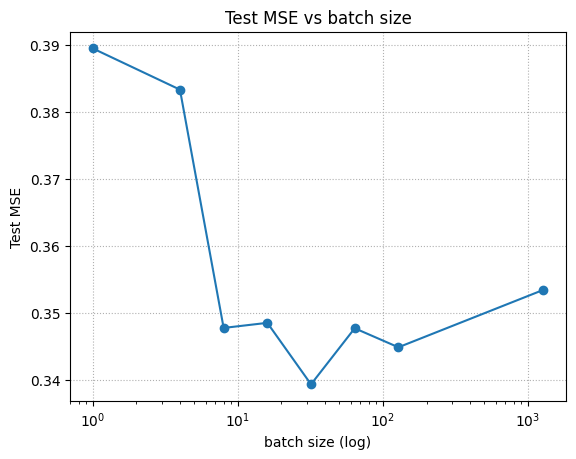

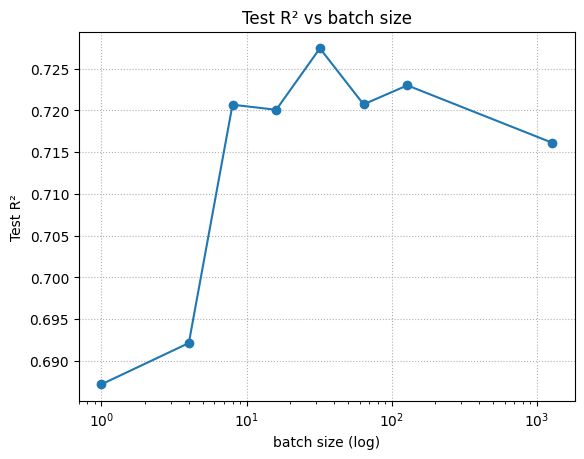

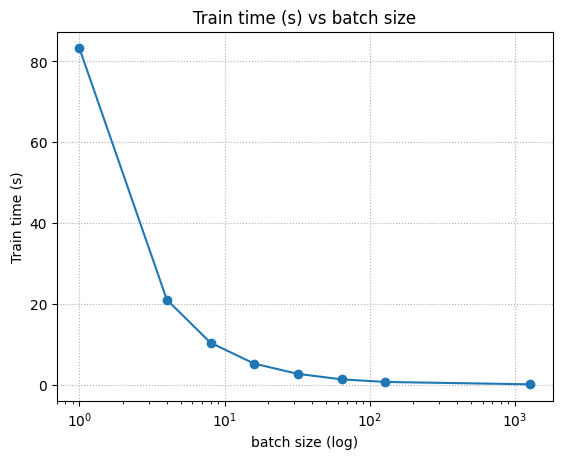

,batch,time_s,peak_MB,mse,r2,FLOPs
0,1,83.2145,0.13,0.38947,0.68716,56276000
1,4,21.0449,0.13,0.38330,0.69211,56320000
2,8,10.3971,0.13,0.34772,0.72069,56320000
3,16,5.2326,0.13,0.34848,0.72008,56320000
4,32,2.6937,0.13,0.33930,0.72745,56320000
5,64,1.3411,0.13,0.34767,0.72073,56320000
6,128,0.6976,0.15,0.34483,0.72301,56320000
7,1279,0.1107,0.39,0.35341,0.71612,56276000


In [4]:
from experiments.batch_analysis import run_batch_experiments
from core.schedulers import ConstantScheduler
import pandas as pd

schedule = ConstantScheduler(lr0=1e-2)

results, figs = run_batch_experiments(
    Xtr_s, ytr, Xte_s, yte,
    batch_sizes=[1, 4, 8, 16, 32, 64, 128, len(Xtr_s)],
    lr_schedule=schedule,
    epochs=1000,
    poly_degree=1,
    plot=True,
)

df = pd.DataFrame(results).sort_values("batch")
df


# Влияние размера батча на Vanilla SGD (Constant LR)

---

## ⚙️ Используемые методы

| Метод              | Обновление весов                      | Параметры эксперимента                              |
|--------------------|---------------------------------------|-----------------------------------------------------|
| **SGDRegressor**   | $$w \leftarrow w - \alpha\,\nabla$$   | lr = 1e-2 (постоянный), без регуляризации, <br> epochs = 10000, poly_degree = 1 |

---

## 📊 Результаты экспериментов

| batch | time_s | peak_MB | testMSE | testR²  |
|------:|-------:|--------:|--------:|--------:|
|     1 |  0.581 |    0.13 |  0.4298 | 0.6548 |
|     4 |  0.595 |    0.13 |  0.3633 | 0.7082 |
|     8 |  0.600 |    0.13 |  0.3560 | 0.7141 |
|    16 |  0.607 |    0.13 |  0.3513 | 0.7178 |
|    32 |  0.613 |    0.13 |  0.3475 | 0.7209 |
|    64 |  0.628 |    0.13 |  0.3442 | 0.7235 |
|   128 |  0.684 |    0.15 |  0.3448 | 0.7230 |
|  1279 |  1.092 |    0.39 |  0.3451 | 0.7228 |

---

## 🧠 Выводы

- **Точность** (testMSE) **улучшается** с ростом batch_size:
  от 0.4298 (bs=1) до ~0.3442 (bs=64), затем немного растёт.
- **R²** растёт от ~0.655 до ~0.724 при увеличении батча до 64 и затем стабилизируется.
- **Время обучения** мало зависит от bs до ~128, но заметно возрастает при полном батче (bs=N).
- **Рекомендация:** на данном датасете оптимален batch_size ≈ 64 —
  баланс между скоростью, стабильностью градиента и качеством модели.
